Implementation of Crane-Droesch's algorithm in pytorch, for better reproducibility.
See the original paper [here](https://iopscience.iop.org/article/10.1088/1748-9326/aae159)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random as rn
from patsy import dmatrices
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import timeit

In [2]:
base = "/Users/max/Documents/climate_and_agriculture/code/" # set your own directory here
df = pd.read_csv(base + "data/iowa_weather.csv")
df = df.drop(columns = 'Unnamed: 0')
field = 'cornyield'
df['log' + field] = np.log(df[field])
df = df.dropna(axis=0, subset=['log'+ field])
df.head()

,fips,year,cornyield,cottonyield,soyyield,prec_101,prec_102,prec_103,prec_104,prec_105,...,tMax_1223,tMax_1224,tMax_1225,tMax_1226,tMax_1227,tMax_1228,tMax_1229,tMax_1230,tMax_1231,logcornyield
0,19001,1951.0,36.7,NaN,21.6,0.012033,0.589944,0.016872,0.013338,0.012083,...,-7.547232,-10.325850,-7.136567,-7.685323,-6.439754,1.537972,6.898899,4.773990,2.318576,3.602777
1,19003,1951.0,29.3,NaN,16.4,0.012352,0.466833,0.017530,0.014132,0.012457,...,-6.751188,-8.839404,-7.620637,-7.860257,-6.613001,1.977630,5.981259,4.881736,2.989506,3.377588
2,19005,1951.0,49.4,NaN,12.5,0.010945,0.290628,0.375549,0.081220,0.431489,...,-12.687468,-13.181018,-5.470778,-8.814853,-11.140276,-1.914674,3.245067,2.077545,2.868546,3.899950
3,19007,1951.0,29.0,NaN,18.9,0.011618,0.578579,0.711192,0.190579,0.011618,...,-6.857291,-10.774097,-5.085959,-7.094800,-5.920215,2.955707,5.388830,4.523667,10.219614,3.367296
4,19009,1951.0,50.2,NaN,24.5,0.009158,0.599447,0.009177,0.009167,0.009159,...,-9.321472,-10.493649,-8.044870,-8.837232,-7.460020,-0.166930,5.955386,4.289409,1.768050,3.916015


In [3]:
# partition the covariates
y = df[["log" + field]]
fe = df[["fips"]]
parametric = None
nonparametric = df[df.columns[pd.Series(df.columns).str.contains("_")]]
NP = torch.tensor(nonparametric.values)

In [4]:
def groupmeans(G, X):
    gm = pd.concat([G, X], axis = 1).groupby(G.columns[0], axis = 0).mean()
    GM = np.empty(shape = X.shape)
    for j in np.unique(G.values):
        idx = np.where(j == G.values)[0]
        toput = np.repeat(gm.loc[j,].values.reshape(1,GM.shape[1]), repeats = len(idx), axis = 0)
        GM[idx,:] = toput
    return GM

# ols function
def ols(X, y, lam = 0, parapen = None):
    # default value is unpenalized
    if parapen is None:
        parapen = np.zeros(X.shape[1])
    # sanity check
    assert (len(parapen) == X.shape[1]), "wrong length for parapen"
    penmat = np.diag(parapen*lam)
    # Moore Pensore pseudoinverse handles singular matrices
    b = np.dot(np.linalg.pinv(np.dot(X.T, X)+ penmat), np.dot(X.T, y))
    return(b)

# function to get FE estimates
def getfe(b, GMx, GMy):
    fe = GMy - np.dot(GMx, b)
    return fe

# mse function
def mse(x, y):
    return ((x-y)**2).mean()

In [5]:
class SPNN(nn.Module):
    def __init__(self, fe_in_dim, P_in_dim=0, nnodes=None, nlayers = 10, 
                 NP_out_dim=1, NP_in_dim=365 * 4, dropout = 0.0,
                batch_normalize=True):
        super(SPNN, self).__init__()
        
        if nnodes is None:
            nnodes = np.repeat(25, nlayers)
        if nnodes[-1] != NP_out_dim:
            nnodes[-1] = nnodes[-1]**0 * NP_out_dim
        
        self.lin1 = nn.Linear(NP_in_dim, nnodes[0])
        self.bn_1 = nn.BatchNorm1d(num_features=nnodes[0])
        self.linears = nn.ModuleList([nn.Linear(nnodes[i], nnodes[i + 1]) for i in range(nlayers - 1)])
        self.bn_list = nn.ModuleList([nn.BatchNorm1d(num_features=nnodes[i+1]) for i in range(nlayers - 1)])
        self.dropout = nn.Dropout(dropout)
        
        self.lin_fe = nn.Linear(fe_in_dim, 1, bias=False)
        cat_dim = 1 + NP_out_dim + P_in_dim
        self.linout = nn.Linear(cat_dim, 1, bias=False)
        self.batch_normalize = batch_normalize
        self.params = {'nnodes': nnodes, 'nlayers': nlayers, 'NP_out_dim': NP_out_dim, 'NP_in_dim': NP_in_dim,
                      'batch_normalize': batch_normalize}

    def forward(self, NP, FE, P = None):
        # Find a way to do batch normalization here
        x = self.lin1(NP)
        x = F.relu(self.dropout(x))
        if self.batch_normalize:
            x = self.bn_1(x)
        for i, l in enumerate(self.linears):
            x = F.relu(self.dropout(l(x)))
            if self.batch_normalize:
                x = self.bn_list[i](x)
        fe = self.lin_fe(FE)
        if P is None:
            concat = torch.cat((fe, x), dim=1)
        else:
            concat = torch.cat((fe, P, x), dim=1)
        return self.linout(concat)
    
    def top_layer(self, NP, FE, P = None):
        x = self.lin1(NP)
        x = F.relu(self.dropout(x))
        if self.batch_normalize:
            x = self.bn_1(x)
        for i, l in enumerate(self.linears):
            x = F.relu(self.dropout(l(x)))
            if self.batch_normalize:
                x = self.bn_list[i](x)
        if P is None:
            return x
        else:
            return torch.cat((P, x), dim=1)

In [6]:
def unpack_data(data, P=None):
    if P is None:
        _NP, _FE, _Y = data
        _P = None
    else:
        _NP, _FE, _P, _Y = data
    return (_NP, _FE, _P, _Y)

def predict(net, NP, fe, y, P):
    FE = torch.tensor(dmatrices("1~ C(fips)-1", fe)[1])
    Y = torch.tensor(y.values)
    NP_in_dim = NP.size()[1]
    FE_in_dim = FE.size()[1]
    if P is None:
        P_in_dim = 0
        dataset = torch.utils.data.TensorDataset(NP, FE, Y)  
    else:
        P_in_dim = P.size()[1]
        dataset = torch.utils.data.TensorDataset(NP, FE, P, Y)  
    loader = torch.utils.data.DataLoader(dataset, batch_size=100,
                                            shuffle=False, num_workers=1)
    return predict_from_loader(loader, net, P)

def predict_from_loader(loader, net, P):
    net.eval()
    predictions = None
    actual = None
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            _NP, _FE, _P, _Y = unpack_data(data, P)
            batch_predictions = net(_NP, _FE, _P).data.numpy()
            if predictions is None:
                predictions = batch_predictions
            else:
                predictions = np.append(predictions, batch_predictions)
            if actual is None:
                actual = _Y.numpy()
            else:
                actual = np.append(actual, _Y.numpy())
    return actual, predictions

def test_SPNN(net, NP, fe, y, P):
    FE = torch.tensor(dmatrices("1~ C(fips)-1", fe)[1])
    Y = torch.tensor(y.values)
    NP_in_dim = NP.size()[1]
    FE_in_dim = FE.size()[1]
    if P is None:
        P_in_dim = 0
        test_dataset = torch.utils.data.TensorDataset(NP, FE, Y)  
    else:
        P_in_dim = P.size()[1]
        test_dataset = torch.utils.data.TensorDataset(NP, FE, P, Y)  
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                            shuffle=False, num_workers=1)
    actual, predictions = predict_from_loader(testloader, net, P)
    print(mse(actual, predictions))

def fit_with_ols(y, P, NP, fe, # input data
                 dropout, batch_normalize, # tunable hyperparameters
                 batch_size, epochs, LR, # training parameter
                 nnodes, NP_out_dim, nlayers, # architecture
                 verbose=True):
    FE = torch.tensor(dmatrices("1~ C(fips)-1", fe)[1])
    Y = torch.tensor(y.values)
    NP_in_dim = NP.size()[1]
    FE_in_dim = FE.size()[1]
    if P is None:
        P_in_dim = 0
        train_dataset = torch.utils.data.TensorDataset(NP, FE, Y)
    else:
        P_in_dim = P.size()[1]
        train_dataset = torch.utils.data.TensorDataset(NP, FE, P, Y)  
    
    net = SPNN(fe_in_dim=FE_in_dim, P_in_dim=P_in_dim, nnodes=nnodes, nlayers = nlayers, 
                 NP_out_dim=NP_out_dim, NP_in_dim=NP_in_dim, dropout = dropout,
                batch_normalize=batch_normalize)
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    criterion = torch.nn.MSELoss()
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=1)
    start_time = timeit.default_timer()
    for epoch in range(epochs): 
        running_loss = 0.0
        net = net.double() 
        net.train()
        for i, data in enumerate(trainloader, 0):
            _NP, _FE, _P, _Y = unpack_data(data, P)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(_NP, _FE, _P)
            loss = criterion(outputs, _Y.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += float(loss)
        if verbose: print("Epoch " + str(epoch + 1) + ", mse " + str(running_loss / (i + 1)))  
    # This section implements the 'OLS trick'
    with torch.no_grad():
        top_layer_inputs = net.top_layer(NP=NP, FE=FE).numpy()
        xbar = groupmeans(fe, pd.DataFrame(top_layer_inputs))
        ybar = groupmeans(fe, y)
        newb = ols(X = top_layer_inputs - xbar, 
                y = np.array(y) - ybar)
        alpha = getfe(newb, xbar, ybar)
        alpha = pd.concat([fe, pd.DataFrame(alpha)], axis = 1).groupby(by = "fips").mean()
        net.linout.weight = torch.nn.parameter.Parameter(torch.tensor(np.concatenate((np.ones((1, 1)), newb), axis=1)))
        net.lin_fe.weight = torch.nn.parameter.Parameter(torch.tensor(alpha.values.reshape(1, -1)))
    elapsed = timeit.default_timer() - start_time
    if verbose: 
        print('MSE after OLS trick:')
        test_SPNN(net, NP, fe, y, P)
        print('Elapsed time, seconds: ' + str(elapsed))
    return net

Epoch 1, mse 19.580916456941093
Epoch 2, mse 11.563215538086116
Epoch 3, mse 2.5104541617369356
Epoch 4, mse 0.09825290351995082
Epoch 5, mse 0.03176246844376008
MSE after OLS trick:
0.029349656683673262
Elapsed time, seconds: 3.0869250618852675
MSE on test set:
0.02893234303953883


Text(0, 0.5, 'predicted')

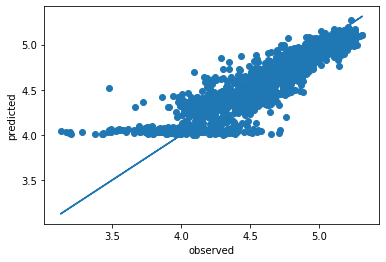

In [7]:
random=1234
torch.manual_seed(random + 2)
np.random.seed(random * 3)
rn.seed(random * 3)
NP = torch.tensor(nonparametric.values)
tr_idx, te_idx = train_test_split(range(len(y)), test_size=0.3)
# tr_idx = np.where(df.year < 2005)[0]
# te_idx = np.where(df.year >= 2005)[0]
net = fit_with_ols(y=y.iloc[tr_idx, :], P=None, NP=NP[tr_idx, :], fe=fe.iloc[tr_idx, :], # input data
            dropout = 0.0, batch_normalize = True, 
            batch_size = 100, epochs = 5, LR = 0.01,
            nnodes = None, NP_out_dim = 1, nlayers = 10,
            verbose=True)
print("MSE on test set:")
test_SPNN(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])
actual, predicted = predict(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])
plt.scatter(actual, predicted)
plt.plot(actual, actual)
plt.xlabel("observed")
plt.ylabel("predicted")

Epoch 1, mse 19.580916456941093
Epoch 2, mse 11.563215538086116
Epoch 3, mse 2.5104541617369356
Epoch 4, mse 0.09825290351995082
Epoch 5, mse 0.03176246844376008
Epoch 6, mse 0.0259762000172062
Epoch 7, mse 0.021354045353752037
Epoch 8, mse 0.017580332189366304
Epoch 9, mse 0.018034091051415884
Epoch 10, mse 0.016878595772360658
MSE after OLS trick:
0.023520504886932664
Elapsed time, seconds: 5.360809043981135
MSE on test set:
0.020961691171938072


Text(0, 0.5, 'predicted')

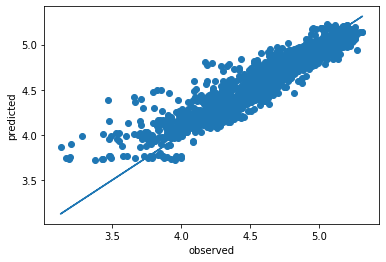

In [68]:
random=1234
torch.manual_seed(random + 2)
np.random.seed(random * 3)
rn.seed(random * 3)
NP = torch.tensor(nonparametric.values)
tr_idx, te_idx = train_test_split(range(len(y)), test_size=0.3)
# tr_idx = np.where(df.year < 2005)[0]
# te_idx = np.where(df.year >= 2005)[0]
net = fit_with_ols(y=y.iloc[tr_idx, :], P=None, NP=NP[tr_idx, :], fe=fe.iloc[tr_idx, :], # input data
            dropout = 0.0, batch_normalize = True, 
            batch_size = 100, epochs = 10, LR = 0.01,
            nnodes = None, NP_out_dim = 1, nlayers = 10,
            verbose=True)
print("MSE on test set:")
test_SPNN(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])
actual, predicted = predict(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])
plt.scatter(actual, predicted)
plt.plot(actual, actual)
plt.xlabel("observed")
plt.ylabel("predicted")

In [48]:
random=1234
torch.manual_seed(random + 2)
np.random.seed(random * 3)
rn.seed(random * 3)
tr_idx, te_idx = train_test_split(range(len(y)), test_size=0.3)
# tr_idx = np.where(df.year < 2005)[0]
# te_idx = np.where(df.year >= 2005)[0]
net = fit_with_ols(y=y.iloc[tr_idx, :], P=None, NP=NP[tr_idx, :], fe=fe.iloc[tr_idx, :], # input data
            dropout = 0.0, batch_normalize = True, 
            batch_size = 100, epochs = 10, LR = 0.01,
            nnodes = None, NP_out_dim = 1, nlayers = 10,
            verbose=True)
print("MSE on test set:")
test_SPNN(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])

Epoch 1, mse 19.580916456941093
Epoch 2, mse 11.563215538086116
Epoch 3, mse 2.5104541617369356
Epoch 4, mse 0.09825290351995082
Epoch 5, mse 0.03176246844376008
Epoch 6, mse 0.0259762000172062
Epoch 7, mse 0.021354045353752037
Epoch 8, mse 0.017580332189366304
Epoch 9, mse 0.018034091051415884
Epoch 10, mse 0.016878595772360658
MSE after OLS trick:
0.023520504886932664
Elapsed time, seconds: 5.651581092970446
MSE on test set:
0.020961691171938072


In [49]:
random=1234
torch.manual_seed(random + 2)
np.random.seed(random * 3)
rn.seed(random * 3)
# tr_idx, te_idx = train_test_split(range(len(y)), test_size=0.3)
tr_idx = np.where(df.year < 2005)[0]
te_idx = np.where(df.year >= 2005)[0]
net = fit_with_ols(y=y.iloc[tr_idx, :], P=None, NP=NP[tr_idx, :], fe=fe.iloc[tr_idx, :], # input data
            dropout = 0.0, batch_normalize = True, 
            batch_size = 100, epochs = 10, LR = 0.01,
            nnodes = None, NP_out_dim = 1, nlayers = 10,
            verbose=True)
print("MSE on test set:")
test_SPNN(net = net, y=y.iloc[te_idx, :], P=None, NP=NP[te_idx, :], fe=fe.iloc[te_idx, :])

Epoch 1, mse 18.18769191661797
Epoch 2, mse 6.9732871473758715
Epoch 3, mse 0.34330591483491707
Epoch 4, mse 0.03226341017972963
Epoch 5, mse 0.020035450014373388
Epoch 6, mse 0.01713831098743937
Epoch 7, mse 0.016529824488094695
Epoch 8, mse 0.015980792028404193
Epoch 9, mse 0.014479306269528106
Epoch 10, mse 0.014507535048611927
MSE after OLS trick:
0.010809162544461058
Elapsed time, seconds: 6.165436386014335
MSE on test set:
0.22580215550244265
